<a href="https://colab.research.google.com/github/taomasgonzalez/Electrocardiogram-LMS/blob/master/Electrocardiogram_anomalies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectando anomalías en Electrocardiogramas (ECG)

## Imports

Instalamos las librerías necesarias

In [14]:
!pip install wfdb
!pip install padasip

Importamos las librerías necesarias

In [0]:
# https://github.com/MIT-LCP/wfdb-python
# https://wfdb.readthedocs.io/en/latest/
import numpy as np
import wfdb
import matplotlib.pyplot as plt
import padasip as pa

Clonamos el repositorio de github:

In [16]:
!git clone "https://github.com/taomasgonzalez/Electrocardiogram-LMS.git"

fatal: destination path 'Electrocardiogram-LMS' already exists and is not an empty directory.


## Obtención de los datos

Obtenemos los datos de electrocardiogramas realizados a múltiples pacientes del MIT-BIH Arrhythmia Database (https://physionet.org/content/mitdb/1.0.0/).

Para más información sobre su contenido y las particularidades con las que los datos fueron obtenidos, visitar la página.

### Definición de funciones de obtención de datos del dataset

In [0]:
def get_data(file_path, sampto='end'):
  """
  get_data devuelve las señales del primer y segundo canal de un archivo que cumple con el estándar wfdb,
  la metadata del mismo y las anotaciones del mismo en caso de haberlas (archivo con el mismo nombre pero con extensión .atr)
  
  Parámetros:
    file_path: path del archivo de donde conseguir las señales a leer.
    sampto: cantidad de samples a leer. Si 'end', lee todas las samples del archivo.
  Returns:
    signal_0: Señal del primer canal.
    signal_1: Señal del segundo canal.
    metadata: metadata que contiene, entre otras cosas, la sample frequency utilizada para tomar los datos.
    annotation: anotaciones correspondientes al archivo
  """
  # Cada columna de la matriz signals es un canal de las señales grabadas del paciente(signals[0] es el primer canal)
  # metadata tiene información como la sample frequency, importante para el resto del trabajo.
  signals, metadata = wfdb.rdsamp(record_name=file_path, sampto=sampto)
  annotation = wfdb.rdann(record_name=file_path, extension='atr', sampto=sampto)
  
  return signals[:,0], signals[:,1], metadata, annotation

### Obtención de las señales

Definimos que archivos obtendremos están presentes en dataset, quer serán los archivos que extraeremos

In [0]:
all_signals = {str(i): dict() for j in (range(100, 125), range(200, 224)) for i in j}
# borramos del dictionary a los archivos que no estan pero que fueron agregados por comodidad
for i in ['110', '120', '204','206','211','216','218']: del all_signals[i]   
all_signals['228'] = None
for i in range(230,235) : all_signals[str(i)] = None

Obtenemos las señales de cada canal, en conjunto con su metadata y las anotaciones que corresponden a la presencia de anomalía o no.

In [0]:
for signal_name in all_signals.keys():
  upper_signal, lower_signal, metadata, annotations =  get_data(file_path='/content/Electrocardiogram-LMS/data/' + signal_name,sampto=None)
  all_signals[signal_name] = {'upper' : upper_signal, 'lower' : lower_signal, 'meta':metadata, 'annot': annotations} 

Visualizamos alguna de las señales:

Hacemos un plot de los primeros 1000 samples de una de las señales de uno de los pacientes

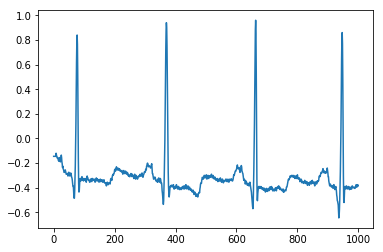

In [20]:
plt.plot(all_signals[list(all_signals.keys())[0]]['upper'][:1000])

### Anotaciones

Visualizamos la clase anotaciones, cómo está estructurada internamente.


In [21]:
anot = all_signals[list(all_signals.keys())[0]]['annot']
attrs = vars(anot)
print ('\n'.join("%s: %s" % item for item in attrs.items()))

record_name: 100
extension: atr
sample: [    18     77    370 ... 649484 649734 649991]
symbol: ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'

Cambiamos todas las anotaciones a un formato binario de tipo "anómala" ('A') o "no anómala" ('N'). 
Visualizamos luego el resultado de un fragmento de una señal de un paciente.

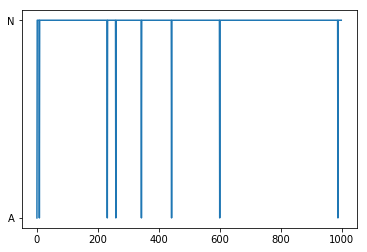

In [22]:
for key in all_signals.keys():
  anot = all_signals[key]['annot']
  anot.symbol = ['A' if i is not 'N' else 'N' for i in anot.symbol]

anot = all_signals[list(all_signals.keys())[0]]['annot']
plt.plot(anot.symbol[0:1000])

## Implementación del filtro adaptativo

In [0]:
# https://matousc89.github.io/padasip/sources/filters/lms.html#references
# https://matousc89.github.io/padasip/_modules/padasip/filters/lms.html#FilterLMS
class FilterLMS():
    """
    This class represents an adaptive LMS filter.

    **Args:**

    * `n` : length of filter (integer) - how many input is input array
      (row of input matrix)

    **Kwargs:**

    * `mu` : learning rate (float). Also known as step size. If it is too slow,
      the filter may have bad performance. If it is too high,
      the filter will be unstable. The default value can be unstable
      for ill-conditioned input data.

    * `w` : initial weights of filter. Possible values are:
        
        * array with initial weights (1 dimensional array) of filter size
    
        * "random" : create random weights
        
        * "zeros" : create zero value weights
    """
    
    def __init__(self, n, w='zeros', mu=0.01):
        self.n = n
        self.mu = mu
        if w is 'zeros':
          self.w = np.zeros(self.n)
        else:  
          if len(w) is self.n: 
            self.w = np.array(w)
          else:
            raise ValueError('The size of filter must be the same as the size of the weights vector')
        
        self.w_history = False
        self.input = np.array([])
        self.desired_response = np.array([])
        self.y = np.array([])
        self.e = np.array([])
        
    def adapt(self, d, x):
        """
        Adapt weights according one desired value and its input.

        **Args:**

        * `d` : desired value (float)

        * `x` : input array (1-dimensional array)
        """
        y = np.dot(self.w, x)
        e = d - y
        self.w += self.mu * e * x        
        return y, e  
      
    def run(self, input_signal, desired_response):
      self.desired_response = desired_response[self.n+1:]
      self.input_signal = input_signal
      self.y = np.array([])
      self.e = np.array([])
      
      for i in range(len(self.desired_response)):
        if i+self.n <= len(self.input_signal):
          y, e = self.adapt(self.desired_response[i], self.input_signal[i:i+self.n])
          self.y = np.concatenate((self.y, np.array([y])), axis=0)
          self.e = np.concatenate((self.e, np.array([e])), axis=0)
        else:
          break
        
      return self.y, self.e
    
    def plot(self, x, y, e):
      pass             

In [0]:
def plot_signal_vs_predicted(signal, predicted, error, sampling_size):
  plt.figure(figsize=(15,9))

  plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
  plt.plot(signal[sampling_size-10000:],"b", label="d - target")
  plt.plot(predicted[sampling_size-10000:],"g", label="y - output");plt.legend()

  plt.subplot(212);plt.title("Filter error");plt.xlabel("samples - k")
#   plt.plot(10*np.log10(error**2),"r", label="e^2 - squared error [dB]");plt.legend()
  plt.plot(error,"r", label="error");plt.legend()

  plt.tight_layout()
  plt.show()

In [0]:
filter_size = 1000
predictor_filter = FilterLMS(n=filter_size, w='zeros', mu=0.005)
sampling_size = 300000
upper_signal = all_signals[list(all_signals.keys())[0]]['upper'][:sampling_size]
y, e = predictor_filter.run(input_signal=upper_signal, desired_response=upper_signal)
y = np.append(np.zeros(filter_size), y)

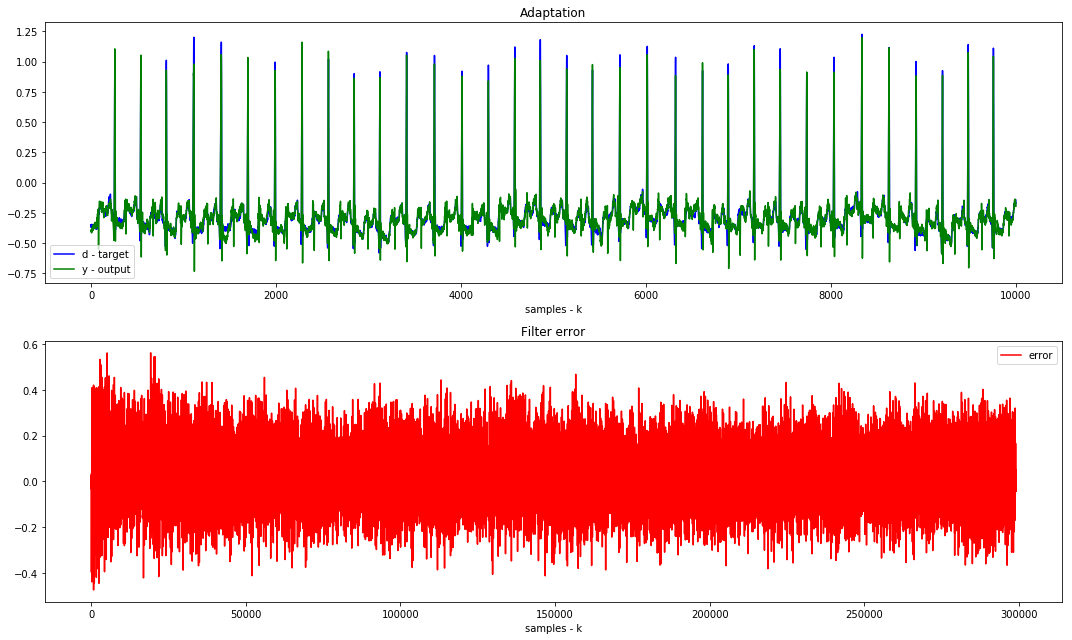

In [78]:
plot_signal_vs_predicted(signal=upper_signal, predicted=y, error=e, sampling_size=sampling_size)


## Implementación del detector de anomalías

### Implementación del detector

In [0]:
def detect_anomalies(input_signal):
  pass

### Cálculo de performance del detector

## Probando al detector

## Resultados